In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

In [3]:
class PatchEmbed(nn.Module):
    def __init__(self, in_channels=3, patch_size=4, embed_dim=96):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: (B, 3, H, W)
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2).transpose(1, 2)  # (B, N, embed_dim)
        return x

This `PatchEmbed` class is a **PyTorch module** designed to convert an input image (typically a batch of RGB images) into a sequence of patch embeddings, which is a key step in vision transformers like **Swin Transformer** and **ViT (Vision Transformer)**.

---

### 🔍 Code Breakdown

```python
class PatchEmbed(nn.Module):
```

* This defines a new class `PatchEmbed` that inherits from `torch.nn.Module`.

---

```python
def __init__(self, in_channels=3, patch_size=4, embed_dim=96):
```

* `in_channels=3`: assumes input images have 3 channels (RGB).
* `patch_size=4`: divides the image into non-overlapping patches of size 4×4.
* `embed_dim=96`: each patch will be mapped to a 96-dimensional vector.

---

```python
self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
```

* A 2D convolution layer is used to extract patches and project them into embedding space in **one step**.
* `kernel_size=patch_size` and `stride=patch_size` mean this convolution slices the image into **non-overlapping patches** and transforms each into a `embed_dim`-dimensional vector.

---

### 🔁 Forward Pass

```python
def forward(self, x):
    # x: (B, 3, H, W)
```

* Input `x` has shape `(B, 3, H, W)`:

  * `B`: batch size
  * `3`: RGB channels
  * `H`, `W`: height and width of image

---

```python
x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
```

* The convolution extracts `H/patch_size × W/patch_size` patches per image.
* Output shape becomes: `(B, embed_dim, H', W')` where `H' = H // patch_size`, `W' = W // patch_size`.

---

```python
x = x.flatten(2).transpose(1, 2)  # (B, N, embed_dim)
```

* `.flatten(2)`: flattens the last two spatial dimensions into one (e.g., `H' * W' = N` patches).

  * Resulting shape: `(B, embed_dim, N)`
* `.transpose(1, 2)`: swaps dimensions to get: `(B, N, embed_dim)` — the standard input format for transformers.

---

### ✅ Final Output

* A **sequence of patch embeddings** with shape: `(batch_size, num_patches, embed_dim)`
* This mimics the tokenized sequence input used in NLP for transformers.

---

### 🔧 Example:

If `H=W=224` and `patch_size=4`, you'll get:

* `224 / 4 = 56` patches along each dimension → `56 * 56 = 3136` total patches.
* Output shape: `(B, 3136, 96)`

---

In [4]:
def window_partition(x, window_size):
    # x: (B, H, W, C)
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

These two functions — `window_partition` and `window_reverse` — are commonly used in **Swin Transformers** for breaking feature maps into smaller windows and then reconstructing them. This allows **self-attention** to be applied **locally** within windows, reducing computational cost.

---

### 📌 `window_partition(x, window_size)`

#### **Goal:**

Split a 4D tensor into **non-overlapping square windows** of size `window_size × window_size`.

#### **Input:**

* `x`: a tensor of shape `(B, H, W, C)`

  * `B`: batch size
  * `H`, `W`: height and width of the image
  * `C`: channels (embedding dim)
* `window_size`: size of each square window

#### **Process:**

```python
x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
```

* Breaks `H` and `W` into `H // window_size` and `W // window_size` blocks, each of size `window_size`.
* So the new shape becomes:

  * `(B, num_h, window_h, num_w, window_w, C)`

---

```python
windows = x.permute(0, 1, 3, 2, 4, 5)
```

* Rearranges dimensions so that the `window_h` and `window_w` parts are next to each other.

---

```python
.contiguous().view(-1, window_size, window_size, C)
```

* Flattens the batch and spatial blocks into a single batch of windows:

  * Output shape: `(num_windows_total, window_size, window_size, C)`
  * Where `num_windows_total = B * (H // window_size) * (W // window_size)`

---

#### ✅ **Example:**

If `x` has shape `(2, 8, 8, 96)` and `window_size=4`:

* Output: `(2 * 2 * 2 = 8 windows, 4, 4, 96)`

---

### 🔁 `window_reverse(windows, window_size, H, W)`

#### **Goal:**

Reconstruct the original tensor `(B, H, W, C)` from windowed patches.

#### **Input:**

* `windows`: shape `(num_windows, window_size, window_size, C)`
* `window_size`, `H`, `W`: same as used in `window_partition`

---

```python
B = int(windows.shape[0] / (H * W / window_size / window_size))
```

* Calculates batch size from number of windows.
* Assumes: `num_windows = B * (H // ws) * (W // ws)`

---

```python
x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
```

* Reshapes windows back into grid layout, separating spatial and window dimensions.

---

```python
x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
```

* Rearranges the axes to combine windowed structure into original spatial structure.
* Final output: `(B, H, W, C)`

---

### 🧠 Summary:

| Function           | Purpose                                | Input Shape                | Output Shape               |
| ------------------ | -------------------------------------- | -------------------------- | -------------------------- |
| `window_partition` | Divide feature maps into small windows | `(B, H, W, C)`             | `(num_windows, ws, ws, C)` |
| `window_reverse`   | Reconstruct original map from windows  | `(num_windows, ws, ws, C)` | `(B, H, W, C)`             |

In [6]:
class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(0.0)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # each: (B_, num_heads, N, head_dim)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        out = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        return self.proj(out)

This `WindowAttention` class implements **multi-head self-attention (MHSA)** within **local windows**, a key innovation in the **Swin Transformer** architecture.

---

### 🎯 Purpose:

Apply **multi-head self-attention** *within* small windows (e.g., `4x4`, `7x7` patches), rather than over the entire image — making it **computationally efficient** while preserving spatial locality.

---

### 📦 Class Initialization

```python
class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads):
```

* `dim`: Total embedding dimension of input (e.g., 96)
* `window_size`: Size of the window (e.g., 7 for a 7×7 window)
* `num_heads`: Number of attention heads

---

```python
self.head_dim = dim // num_heads
self.scale = self.head_dim ** -0.5
```

* `head_dim`: Each attention head works on a fraction of `dim`
* `scale`: Scaling factor for dot-product attention to stabilize gradients

---

```python
self.qkv = nn.Linear(dim, dim * 3)
```

* Projects input into concatenated **Query**, **Key**, and **Value**:

  * From shape `[B_, N, dim]` → `[B_, N, 3 * dim]`

---

```python
self.attn_drop = nn.Dropout(0.0)
self.proj = nn.Linear(dim, dim)
```

* Dropout for attention weights (0% here)
* Final projection after self-attention to combine head outputs

---

### 🔁 Forward Pass

```python
B_, N, C = x.shape
```

* `x`: input tensor of shape `(B_, N, C)`

  * `B_`: number of windows × batch size
  * `N`: number of patches per window (e.g., `7×7 = 49`)
  * `C`: input embedding dim

---

```python
qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, self.head_dim)
qkv = qkv.permute(2, 0, 3, 1, 4)
q, k, v = qkv[0], qkv[1], qkv[2]
```

* Projects and splits into Q, K, V:

  * Shape of each: `(B_, num_heads, N, head_dim)`
  * Allows attention computation **per head per window**

---

### 🧠 Attention Computation

```python
attn = (q @ k.transpose(-2, -1)) * self.scale
```

* Dot product between queries and keys: `(B_, num_heads, N, N)`
* Each element `attn[i,j,p,q]` measures relevance between patch `p` and patch `q` in window `i`, head `j`

---

```python
attn = attn.softmax(dim=-1)
attn = self.attn_drop(attn)
```

* Softmax normalizes across last dim so attention scores sum to 1 for each query

---

```python
out = (attn @ v).transpose(1, 2).reshape(B_, N, C)
```

* Multiply attention with values → shape: `(B_, num_heads, N, head_dim)`
* Transpose and reshape back to `(B_, N, C)`

---

```python
return self.proj(out)
```

* Final linear projection to transform the combined attention output back to the original dimension

---

### ✅ Summary Table

| Step         | Operation            | Output Shape                        |
| ------------ | -------------------- | ----------------------------------- |
| Input        | `x`                  | `(B_, N, C)`                        |
| QKV Linear   | → q, k, v            | `(B_, num_heads, N, head_dim)` each |
| Attention    | `q @ kᵀ` → softmax   | `(B_, num_heads, N, N)`             |
| Apply to V   | `attn @ v` → reshape | `(B_, N, C)`                        |
| Final Output | `proj(out)`          | `(B_, N, C)`                        |

---

### 🔍 Intuition

This allows each window of patches to **attend to itself** — capturing local relationships without the quadratic cost of global attention.

In [7]:
class SwinBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, window_size=window_size, num_heads=num_heads)
        self.norm2 = nn.LayerNorm(dim)

        mlp_hidden_dim = int(dim * 4)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Linear(mlp_hidden_dim, dim),
        )

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "Input feature has wrong size"

        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # (num_windows*B, window_size, window_size, C)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)

        # attention
        attn_windows = self.attn(x_windows)  # (num_windows*B, window_size*window_size, C)

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        x = x.view(B, H * W, C)

        # FFN
        x = x + self.mlp(self.norm2(x))
        return x

This `SwinBlock` is a **core building block** of the **Swin Transformer**, combining local self-attention and feedforward layers with **window-based attention** and **shifted windows**.

---

### 🧱 Purpose of `SwinBlock`:

* Compute **self-attention within local windows** (using `WindowAttention`)
* Use **shifted windows** (in alternate layers) to enable **cross-window interaction**
* Add a **feedforward network (MLP)** to model richer representations
* Wrap with **LayerNorm** and **residual connections**

---

### 🔧 Constructor: `__init__`

```python
def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0):
```

#### Arguments:

* `dim`: embedding dimension (`C`)
* `input_resolution`: `(H, W)` of the feature map
* `num_heads`: number of attention heads
* `window_size`: size of local attention windows (e.g., 7×7)
* `shift_size`: offset for window partitioning (used in alternating layers)

---

```python
self.norm1 = nn.LayerNorm(dim)
self.attn = WindowAttention(dim, window_size, num_heads)
```

* Apply **LayerNorm** and **windowed self-attention**

```python
self.norm2 = nn.LayerNorm(dim)
self.mlp = nn.Sequential(
    nn.Linear(dim, dim * 4),
    nn.GELU(),
    nn.Linear(dim * 4, dim)
)
```

* Standard **MLP block** with nonlinearity and residual connection

---

### 🔁 Forward Pass

#### 1. **Input Reshaping**

```python
x = x.view(B, H, W, C)
```

* Converts flat sequence `(B, L=H×W, C)` to 4D `(B, H, W, C)` for spatial ops

---

#### 2. **Cyclic Shift (if `shift_size > 0`)**

```python
shifted_x = torch.roll(x, shifts=(-shift_size, -shift_size), dims=(1, 2))
```

* Offsets the feature map spatially to **shift attention windows**
* Introduces **cross-window interaction** in alternating layers

---

#### 3. **Partition into Local Windows**

```python
x_windows = window_partition(shifted_x, self.window_size)
x_windows = x_windows.view(-1, window_size * window_size, C)
```

* Creates non-overlapping windows of shape `(num_windows * B, N, C)`

  * `N = window_size × window_size`

---

#### 4. **Window Attention**

```python
attn_windows = self.attn(x_windows)
```

* Applies **multi-head self-attention** within each window

---

#### 5. **Reverse Partition**

```python
attn_windows = attn_windows.view(-1, window_size, window_size, C)
shifted_x = window_reverse(attn_windows, window_size, H, W)
```

* Reconstruct the shifted spatial feature map from the attended windows

---

#### 6. **Reverse Cyclic Shift (if applied earlier)**

```python
x = torch.roll(shifted_x, shifts=(shift_size, shift_size), dims=(1, 2))
```

* Restores original spatial alignment

---

#### 7. **Flatten**

```python
x = x.view(B, H * W, C)
```

* Return to flattened shape for feedforward and residual ops

---

#### 8. **Feedforward Network (MLP) + Residual**

```python
x = x + self.mlp(self.norm2(x))
```

* Applies MLP block with residual connection after LayerNorm

---

### 🧠 Summary of SwinBlock Steps

| Step         | Description                                  |
| ------------ | -------------------------------------------- |
| 1. Reshape   | Convert input to spatial form `(B, H, W, C)` |
| 2. Shift     | (Optional) Cyclically shift feature map      |
| 3. Partition | Split into local windows                     |
| 4. Attention | Apply windowed MHSA                          |
| 5. Reverse   | Merge windows and reverse shift              |
| 6. MLP       | Apply feedforward network                    |
| 7. Output    | `(B, H×W, C)` after residuals                |

---

### 💡 Why Shifted Windows?

In traditional Swin Transformer:

* Even layers: `shift_size=0` → attention is local within standard windows
* Odd layers: `shift_size = window_size // 2` → attention crosses window boundaries

This allows **hierarchical** and **efficient** modeling of both local and global structure.

---

# data preparation

In [9]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os

class FlowerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

This code defines a custom **PyTorch Dataset** named `FlowerDataset`, designed for **image classification tasks**, such as training a model on a flower dataset. It's used with PyTorch’s `DataLoader` to efficiently load and batch image data during training or inference.

---

### 🔍 Breakdown

#### ✅ Imports

```python
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os
```

* `transforms`: For image preprocessing (resize, crop, normalize, etc.)
* `PIL.Image`: For loading images
* `Dataset`: Base class for all PyTorch datasets
* `DataLoader`: Efficiently loads and batches data from a `Dataset`
* `os`: Used for file path manipulations if needed

---

### 📦 `FlowerDataset` Class

```python
class FlowerDataset(Dataset):
```

Inherits from `torch.utils.data.Dataset`—this makes it compatible with `DataLoader`.

---

### 🔧 `__init__` Method

```python
def __init__(self, image_paths, labels, transform=None):
    self.image_paths = image_paths
    self.labels = labels
    self.transform = transform
```

* `image_paths`: List of image file paths (e.g., `["img1.jpg", "img2.jpg", ...]`)
* `labels`: Corresponding list of labels (e.g., `[0, 1, 2, ...]`)
* `transform`: A torchvision `transform` object (optional); used for preprocessing

---

### 📏 `__len__` Method

```python
def __len__(self):
    return len(self.image_paths)
```

Returns the total number of samples—needed for `DataLoader` to know the size.

---

### 🔄 `__getitem__` Method

```python
def __getitem__(self, idx):
    img_path = self.image_paths[idx]
    label = self.labels[idx]
    image = Image.open(img_path).convert("RGB")
    if self.transform:
        image = self.transform(image)
    return image, label
```

This method retrieves a single data sample:

1. **Load image** using `PIL.Image.open`
2. **Convert to RGB** (ensures consistency)
3. **Apply transform** (e.g., resize, to tensor, normalize)
4. **Return** a tuple `(image_tensor, label)`

---

### 🛠 Example Use

```python
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = FlowerDataset(image_paths, labels, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
```

---

### ✅ Summary

| Component     | Purpose                                           |
| ------------- | ------------------------------------------------- |
| `__init__`    | Stores image paths and labels; sets up transforms |
| `__len__`     | Returns number of samples                         |
| `__getitem__` | Loads and preprocesses an image-label pair        |

This pattern is common in custom image classification tasks using PyTorch.

In [ ]:
def load_data_from_folders(base_dir="flower_classification"):
    def get_paths_and_labels(folder):
        classes = sorted(os.listdir(folder))
        class_to_idx = {cls: i for i, cls in enumerate(classes)}

        image_paths, labels = [], []
        for cls in classes:
            cls_folder = os.path.join(folder, cls)
            for img in os.listdir(cls_folder):
                image_paths.append(os.path.join(cls_folder, img))
                labels.append(class_to_idx[cls])
        return image_paths, labels, class_to_idx

    train_paths, train_labels, class_to_idx = get_paths_and_labels(os.path.join(base_dir, "train"))
    val_paths, val_labels, _ = get_paths_and_labels(os.path.join(base_dir, "validation"))
    test_paths, test_labels, _ = get_paths_and_labels(os.path.join(base_dir, "test"))
    
    return (train_paths, train_labels, val_paths, val_labels, test_paths, test_labels, class_to_idx)

In [19]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

(train_paths, train_labels,
 val_paths, val_labels,
 test_paths, test_labels,
 class_to_idx) = load_data_from_folders("flower_classification")

idx_to_class = {v: k for k, v in class_to_idx.items()}
num_classes = len(class_to_idx)


train_dataset = FlowerDataset(train_paths, train_labels, transform=train_transform)
val_dataset   = FlowerDataset(val_paths, val_labels, transform=val_transform)
test_dataset  = FlowerDataset(test_paths, test_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# building the classifier

In [20]:
class SimpleSwinClassifier(nn.Module):
    def __init__(self, image_size=224, patch_size=4, in_chans=3, embed_dim=96, num_heads=3, window_size=7, num_classes=5):
        super().__init__()
        self.patch_embed = PatchEmbed(in_channels=in_chans, patch_size=patch_size, embed_dim=embed_dim)
        self.num_patches = (image_size // patch_size) ** 2
        self.input_resolution = (image_size // patch_size, image_size // patch_size)

        self.block1 = SwinBlock(embed_dim, self.input_resolution, num_heads=num_heads, window_size=window_size, shift_size=0)
        self.block2 = SwinBlock(embed_dim, self.input_resolution, num_heads=num_heads, window_size=window_size, shift_size=window_size//2)

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)  # (B, N, C)
        x = self.block1(x)
        x = self.block2(x)
        x = self.norm(x)
        x = x.mean(1)  # Global average pooling
        return self.head(x)

This code defines a simple image classification model called `SimpleSwinClassifier` based on **key ideas from the Swin Transformer architecture**. It processes an input image through patch embedding, local windowed self-attention blocks, and outputs class predictions.

---

### 🧱 What this model does:

* Takes an input image (e.g., 3×224×224 RGB)
* Splits the image into patches and embeds each patch into a vector
* Applies two sequential **Swin Transformer blocks** (with and without window shifting)
* Normalizes features and aggregates them globally
* Classifies the aggregated features into `num_classes` output categories

---

### 🔧 Constructor: `__init__`

```python
def __init__(self, image_size=224, patch_size=4, in_chans=3, embed_dim=96, num_heads=3, window_size=7, num_classes=5):
```

#### Arguments:

* `image_size=224`: Input image height & width (assumed square)
* `patch_size=4`: Size of non-overlapping patches
* `in_chans=3`: Number of input channels (RGB images)
* `embed_dim=96`: Dimensionality of patch embeddings
* `num_heads=3`: Number of attention heads in each Swin block
* `window_size=7`: Size of local attention windows
* `num_classes=5`: Number of output classes for classification

---

### Key Modules Initialized

```python
self.patch_embed = PatchEmbed(in_channels=in_chans, patch_size=patch_size, embed_dim=embed_dim)
```

* Converts input images `(B, 3, 224, 224)` into patch embeddings `(B, N, embed_dim)`, where
  $N = \left(\frac{224}{4}\right)^2 = 56 \times 56 = 3136$

```python
self.num_patches = (image_size // patch_size) ** 2
self.input_resolution = (image_size // patch_size, image_size // patch_size)
```

* Stores the number and resolution of patches for later use (e.g., reshaping)

```python
self.block1 = SwinBlock(embed_dim, self.input_resolution, num_heads=num_heads, window_size=window_size, shift_size=0)
self.block2 = SwinBlock(embed_dim, self.input_resolution, num_heads=num_heads, window_size=window_size, shift_size=window_size//2)
```

* Two Swin Transformer blocks:

  * `block1`: standard windowed self-attention (no shift)
  * `block2`: shifted window attention to enable cross-window context

```python
self.norm = nn.LayerNorm(embed_dim)
self.head = nn.Linear(embed_dim, num_classes)
```

* LayerNorm for feature normalization
* Linear layer as classification head outputting logits for each class

---

### 🔁 Forward Method

```python
def forward(self, x):
    x = self.patch_embed(x)  # (B, N, C)
    x = self.block1(x)
    x = self.block2(x)
    x = self.norm(x)
    x = x.mean(1)  # Global average pooling over patches
    return self.head(x)
```

* **Step-by-step:**

1. **Patch embedding**:
   Convert image to sequence of patch embeddings `(B, N, C)`
2. **Block 1**:
   Local window attention without shift
3. **Block 2**:
   Local window attention with shifted windows
4. **LayerNorm**:
   Normalize feature embeddings
5. **Global average pooling**:
   Average across all patches (dim=1), resulting in `(B, C)`
6. **Classification head**:
   Linear projection to output class logits `(B, num_classes)`

---

### 🔑 Summary

| Component           | Purpose                                                    |
| ------------------- | ---------------------------------------------------------- |
| `PatchEmbed`        | Convert image to patch embeddings                          |
| `SwinBlock` (2x)    | Window-based self-attention layers with and without shifts |
| `LayerNorm`         | Normalize features                                         |
| Global Average Pool | Aggregate patch features                                   |
| `Linear` Head       | Produce class logits                                       |

---

### 🖼️ Intuition

This model is a **mini Swin Transformer classifier** that leverages:

* Efficient local window attention (vs. global attention)
* Shifted windows for cross-window communication
* Patch-based tokenization of images

to produce robust image classification predictions for tasks like flower classification.

---

# model training

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleSwinClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad() # Clear gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward() # Compute gradients
        optimizer.step() # Update model parameters

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    
    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    
    return total_loss / len(loader), correct / len(loader.dataset)

In [23]:
epochs = 10

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1/10 - Train Loss: 1.4029, Acc: 0.3633 | Val Loss: 1.2984, Acc: 0.5125
Epoch 2/10 - Train Loss: 1.2663, Acc: 0.4568 | Val Loss: 1.1344, Acc: 0.5500
Epoch 3/10 - Train Loss: 1.1923, Acc: 0.4904 | Val Loss: 1.0168, Acc: 0.5875
Epoch 4/10 - Train Loss: 1.1242, Acc: 0.5373 | Val Loss: 0.9679, Acc: 0.6250
Epoch 5/10 - Train Loss: 1.0698, Acc: 0.5647 | Val Loss: 0.9238, Acc: 0.7625
Epoch 6/10 - Train Loss: 1.0417, Acc: 0.5737 | Val Loss: 0.8601, Acc: 0.6625
Epoch 7/10 - Train Loss: 1.0117, Acc: 0.5918 | Val Loss: 0.9181, Acc: 0.7250
Epoch 8/10 - Train Loss: 0.9750, Acc: 0.6102 | Val Loss: 0.8153, Acc: 0.6500
Epoch 9/10 - Train Loss: 0.9520, Acc: 0.6158 | Val Loss: 0.7897, Acc: 0.8000
Epoch 10/10 - Train Loss: 0.9249, Acc: 0.6364 | Val Loss: 0.7532, Acc: 0.7500


In [24]:
torch.save(model.state_dict(), "models/swin_flower_classifier.pth")

In [25]:
model = SimpleSwinClassifier(num_classes=num_classes)
model.load_state_dict(torch.load("models/swin_flower_classifier.pth", map_location=device))
model.to(device)
model.eval()

SimpleSwinClassifier(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
  )
  (block1): SwinBlock(
    (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (attn): WindowAttention(
      (qkv): Linear(in_features=96, out_features=288, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=96, out_features=96, bias=True)
    )
    (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (0): Linear(in_features=96, out_features=384, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=384, out_features=96, bias=True)
    )
  )
  (block2): SwinBlock(
    (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (attn): WindowAttention(
      (qkv): Linear(in_features=96, out_features=288, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=96, out_features=96, bias=True)
    )
    (norm2): Laye

The line:

```python
model.eval()
```

puts the `model` into **evaluation mode**, which is crucial for **inference** (i.e., when you're testing or making predictions).

---

### ✅ What does `.eval()` do?

It changes the behavior of certain layers that behave differently during training and evaluation, specifically:

| Layer Type                | Training Mode (`model.train()`)        | Eval Mode (`model.eval()`)           |
| ------------------------- | -------------------------------------- | ------------------------------------ |
| `Dropout`                 | Randomly drops neurons (adds noise)    | **Disables** dropout (no randomness) |
| `BatchNorm` / `LayerNorm` | Uses batch stats (mean/var from input) | Uses **running stats** from training |

---

### 🔍 Why is it important?

If you **don’t call `model.eval()`**, the model behaves as if it's still training, which:

* Adds noise from `Dropout` layers (if present)
* Uses fresh batch statistics in `BatchNorm` (which can be unstable with small batch sizes)
* Leads to **inconsistent and inaccurate** evaluation or predictions

---

### 🧠 In your case:

You're loading a trained `SimpleSwinClassifier` and using it to make predictions. Since you're **not training**, you need to use:

```python
model.eval()
```

to ensure it behaves correctly during inference.

---

### ✅ Summary

| `.eval()` is used when...        | To ensure...                     |
| -------------------------------- | -------------------------------- |
| You’re evaluating or predicting  | Stable, correct model behavior   |
| You’ve already trained the model | Evaluation uses fixed parameters |

# model inference

In [28]:
import matplotlib.pyplot as plt
from PIL import Image

def infer_image(img_path, model, transform, class_idx_map, show_plot=True):
    image = Image.open(img_path).convert("RGB")
    
    # Apply transform
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        output = model(image_tensor)
        predicted_idx = output.argmax(dim=1).item()

    class_name = class_idx_map[predicted_idx]

    if show_plot:
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.title(f"Predicted: {class_name}")
        plt.axis("off")
        plt.show()

    return class_name

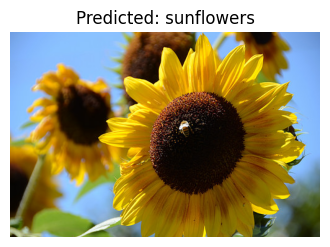

Predicted class: sunflowers


In [29]:
img_path = "flower_classification/test/sunflowers/20342824594_9740b7b160.jpg"
predicted_class = infer_image(img_path, model, val_transform, idx_to_class)
print(f"Predicted class: {predicted_class}")

# using pre-trained swin transformers

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
from torchinfo import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os

/home/mushfiq/anaconda3/envs/vit/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "flower_classification"

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "validation"), transform=val_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_transform)

# Use smaller batch size for CPU
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Number of classes: 5
Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [3]:
device = torch.device("cpu")
print(f"Using device: {device}")

model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=num_classes, global_pool='avg')
model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Using device: cpu


In [4]:
# Display model summary
summary(model, input_size=(16, 3, 224, 224), device=str(device))

Layer (type:depth-idx)                             Output Shape              Param #
SwinTransformer                                    [16, 5]                   --
├─PatchEmbed: 1-1                                  [16, 56, 56, 96]          --
│    └─Conv2d: 2-1                                 [16, 96, 56, 56]          4,704
│    └─LayerNorm: 2-2                              [16, 56, 56, 96]          192
├─Sequential: 1-2                                  [16, 7, 7, 768]           --
│    └─SwinTransformerStage: 2-3                   [16, 56, 56, 96]          --
│    │    └─Identity: 3-1                          [16, 56, 56, 96]          --
│    │    └─Sequential: 3-2                        [16, 56, 56, 96]          224,694
│    └─SwinTransformerStage: 2-4                   [16, 28, 28, 192]         --
│    │    └─PatchMerging: 3-3                      [16, 28, 28, 192]         74,496
│    │    └─Sequential: 3-4                        [16, 28, 28, 192]         891,756
│    └─SwinTransf

In [5]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze()  # Ensure labels are 1D
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze()  # Ensure labels are 1D
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return total_loss / len(loader), correct / len(loader.dataset), all_preds, all_labels

In [6]:
epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1/10 - Train Loss: 0.3189, Acc: 0.8794 | Val Loss: 0.2246, Acc: 0.9500
Epoch 2/10 - Train Loss: 0.1209, Acc: 0.9621 | Val Loss: 0.1158, Acc: 0.9500
Epoch 3/10 - Train Loss: 0.0677, Acc: 0.9794 | Val Loss: 0.1363, Acc: 0.9625
Epoch 4/10 - Train Loss: 0.0482, Acc: 0.9847 | Val Loss: 0.2871, Acc: 0.9375
Epoch 5/10 - Train Loss: 0.0537, Acc: 0.9805 | Val Loss: 0.2111, Acc: 0.9500
Epoch 6/10 - Train Loss: 0.0416, Acc: 0.9864 | Val Loss: 0.1638, Acc: 0.9625
Epoch 7/10 - Train Loss: 0.0397, Acc: 0.9907 | Val Loss: 0.1154, Acc: 0.9500
Epoch 8/10 - Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.1668, Acc: 0.9375
Epoch 9/10 - Train Loss: 0.0492, Acc: 0.9819 | Val Loss: 0.1602, Acc: 0.9500
Epoch 10/10 - Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.2462, Acc: 0.9250


In [7]:
torch.save(model.state_dict(), "models/swin_pretrained_flower_classifier.pth")

Test Loss: 0.2756, Test Accuracy: 0.9000


<Figure size 1000x1000 with 0 Axes>

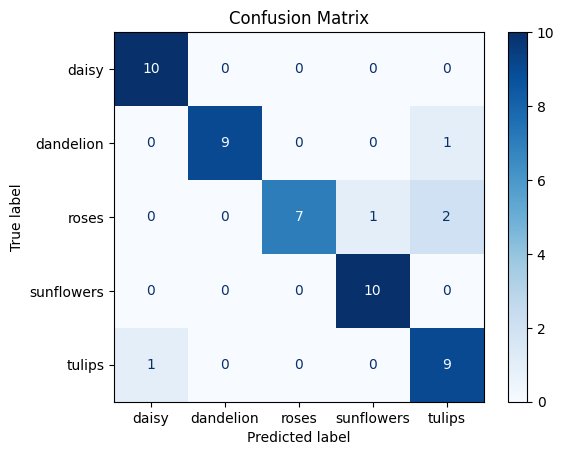

In [8]:
model.eval()
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Compute and plot confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# model inference

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

def infer_image(img_path, model, transform, class_idx_map, device, show_plot=True):
    image = Image.open(img_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        predicted_idx = output.argmax(dim=1).item()
    
    class_name = class_idx_map[predicted_idx]
    
    if show_plot:
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.title(f"Predicted: {class_name}")
        plt.axis("off")
        plt.show()
    
    return class_name

In [10]:
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [11]:
try:
    val_transform
except NameError:
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
    ])

try:
    class_names
except NameError:
    data_dir = "flower_classification"
    test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"))
    class_names = test_dataset.classes
idx_to_class = {i: name for i, name in enumerate(class_names)}
num_classes = len(class_names)
print(f"Class names: {class_names}")

Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [12]:
# Load model and weights
model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=False, num_classes=num_classes, global_pool='avg')
model.load_state_dict(torch.load("models/swin_pretrained_flower_classifier.pth", map_location=device))
model = model.to(device)

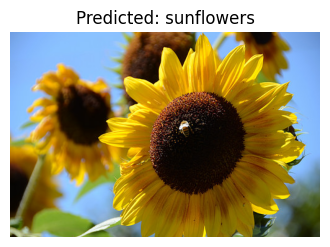

Predicted class: sunflowers


In [13]:
img_path = "flower_classification/test/sunflowers/20342824594_9740b7b160.jpg"
predicted_class = infer_image(img_path, model, val_transform, idx_to_class, device)
print(f"Predicted class: {predicted_class}")

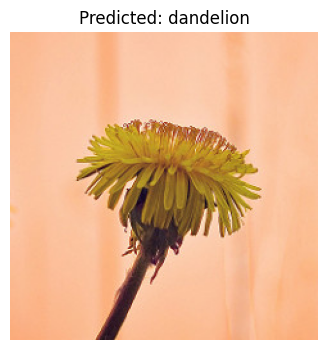

Predicted class: dandelion


In [14]:
img_path = "flower_classification/test/dandelion/7179487220_56e4725195_m.jpg"
predicted_class = infer_image(img_path, model, val_transform, idx_to_class, device)
print(f"Predicted class: {predicted_class}")